# Homework 4: Lab (20 points)

## Name: Student 1 (JHED), Student 2 (JHED)

Please refer to the PDF description for homework 4 for a detailed description of this notebook and the goals of this assignment.

You will hand in a PDF of this notebook. Please be sure to clearly answer each question listed in the homework PDF.

## Setup the code.

In [ ]:
# Turn on GPU backend for this Colab by clicking `Runtime > Change Runtime Type` above.

!pip install torch==1.10.0
!pip install torchtext==0.6.0

import torch
import torchtext
import torchtext.data as data
from torchtext.vocab import Vectors, GloVe
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x65cc2000 @  0x7f90877eb615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.10.0 which is incom

## Define the Neural Network 

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(MLP, self).__init__()
        self.l1 = torch.nn.Linear(input_dim, output_dim) 
        self.l2 = torch.nn.Linear(output_dim, output_dim) 
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.l1(x).relu()
        x = self.dropout(x)
        x = self.l2(x).relu()
        x = self.dropout(x)
        return x

class AttentionModel(torch.nn.Module):
    def __init__(self,
                 TEXT, LABEL,
                 hidden_attn, hidden_aligned, hidden_final,
                 dropout = 0.2, device = 'cpu', freeze_emb = True):
        super().__init__()
        # record parameters
        self.device = device
        self.dropout = dropout

        # initialize embedding
        self.pretrained_emb = TEXT.vocab.vectors.to(device)
        self.embedding = (
            torch.nn.Embedding.from_pretrained(self.pretrained_emb, freeze=freeze_emb)       
                ) # seqlen x embedding
        self.embedding.weight[1] = torch.zeros(300)
        self.embedding_projection = torch.nn.Linear(self.pretrained_emb.shape[1], 200) # embedding x embedding
        emb_dim = 200

        # initialize feedforward modules
        self.feedforward_attn = MLP(emb_dim, hidden_attn, self.dropout) # 'embedding', 'hidden',
        self.feedforward_aligned = MLP(2*emb_dim, hidden_aligned, self.dropout)
        self.feedforward_agg = MLP(2*hidden_aligned, hidden_final, self.dropout)
        self.final_linear = torch.nn.Linear(hidden_final, len(LABEL.vocab))
        self.to(device)

    def forward(self, premise, hypothesis):
        premise = self.embedding(premise)
        premise = self.embedding_projection(premise) #.rename('seqlen', 'seqlenPremise')
        hypothesis = self.embedding(hypothesis)
        hypothesis = self.embedding_projection(hypothesis) #.rename('seqlen', 'seqlenHypo')

        premise_mask = (premise != 0).float()
        hypothesis_mask = (hypothesis != 0).float()

        #attend
        premise_hidden = self.feedforward_attn(premise)
        hypothesis_hidden = self.feedforward_attn(hypothesis)
        
        # matmul: [B, L1, D] * [B, D, L2] -> [B, L1, L2]
        # hypothesis_hidden: L1, B, D
        # premise_hidden: L2, B, D
        hypothesis_hidden = hypothesis_hidden.permute((1,0,2))
        premise_hidden = premise_hidden.permute((1,2,0))
        self.attn = torch.matmul(hypothesis_hidden, premise_hidden)
        #self.attn = premise_hidden.dot(hypothesis_hidden)
        # attn.shape: B, L1, L2
        self.attn_beta = self.attn.softmax(2)
        # premise: L2, B, D -> B, L2, D
        # beta: B, L1, D
        beta = torch.matmul(self.attn_beta, premise.permute((1,0,2)))
        
        # hypothesis: L1, B, D -> B, L1, D
        # attn: B, L1, L2 -> B, L2, L1
        # alpha: B, L2, D
        self.attn_alpha = self.attn.softmax(1).permute((0,2,1))
        alpha = torch.matmul(self.attn_alpha, hypothesis.permute((1, 0, 2)))

        #hypothesis_mask: L1, B, D
        # premise_mask: L2, B, D
        beta = beta.permute((1, 0, 2)) * hypothesis_mask 
        alpha = alpha.permute((1, 0, 2)) * premise_mask 

        #compare
        hypothesis_comparison = self.feedforward_aligned(torch.cat([beta, hypothesis], dim=2)).sum(dim=0) # sum along L1
        premise_comparison = self.feedforward_aligned(torch.cat([alpha, premise], dim=2)).sum(dim=0) # sum along L2
        # B, D

        #aggregate
        agg = torch.cat([premise_comparison, hypothesis_comparison], dim=1) # cat along , 'hidden'
        agg = self.feedforward_agg(agg)
        agg = self.final_linear(agg)
        return agg, self.attn

    def fit(self, train_iter, val_iter=[], lr=0.0001, verbose=True,
            batch_size=128, epochs=100, interval=500):
        self.to(self.device)
        lr = torch.tensor(lr)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_iter.batch_size = batch_size

        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            self.train()
            for i, data in enumerate(train_iter, 0):
                premise, hypothesis, labels = (
                    data.premise,
                    data.hypothesis,
                    data.label
                )

                # forward + backward + optimize
                outputs, _ = self(premise, hypothesis)
                loss = criterion(
                    outputs,
                    labels,
                )
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % interval == 0 and i > 0 and verbose:
                    print(f"batch: {i}, loss: {running_loss/interval}")
                    running_loss = 0
            if verbose and val_iter is not None:
                val_loss = self.validate(val_iter)
                print(f"epoch: {epoch}, val loss: {val_loss}")
        
    def validate(self, val_iter):
        running_loss = 0
        val_count = 0
        self.eval()
        criterion = torch.nn.CrossEntropyLoss()

        for i, data in enumerate(val_iter):
            premise, hypothesis, labels = (
                data.premise,
                data.hypothesis,
                data.label
            )

            outputs, _ = self(premise, hypothesis)
            loss = criterion(
                outputs,
                labels
            )
            running_loss += loss.item()
            val_count += 1
        avg_loss = running_loss / val_count
        return avg_loss

## Load the data

In [ ]:
# The data
# Our input x
TEXT = data.Field()

# Our labels y
LABEL = data.Field(sequential=False,)

train, val, test = torchtext.datasets.SNLI.splits(
    TEXT, LABEL)

pretrained_embedding = 'glove.6B.300d'
embedding_dim = 300
embedding_num = 100


TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test), batch_size=128, device=torch.device("cuda"), repeat=False, shuffle=False) # cpu

# Assign word embeddings.
# Out-of-vocabulary (OOV) words are hashed to one of 100 random embeddings. 
# Initialized to mean 0 and standarad deviation 1.  

unk_vectors = [torch.randn(embedding_dim) for _ in range(embedding_num)]
TEXT.vocab.load_vectors(vectors=pretrained_embedding, unk_init=lambda x:random.choice(unk_vectors))

# Normalize s.t. l_2 norm = 1. 

vectors = TEXT.vocab.vectors
vectors = vectors / vectors.norm(dim=1,keepdim=True)
vectors = torch.tensor(vectors) # dims: word, embedding 
TEXT.vocab.vectors = vectors

# Helper function that converts vocabulary ids to string
def vocab_id_to_string(ids, FIELD):
    string = ""
    if type(ids) == list:
        for id in ids:
            if id != 1: # remove <pad>
                string += " " + FIELD.vocab.itos[id]
    elif type(ids) == int:
        string = FIELD.vocab.itos[ids]
    return string

# Helper function that converts string to vocabulary ids
def string_to_vocab_ids(string):
    vocab_ids = []
    for w in string.strip().split():
        vocab_ids.append(TEXT.vocab.stoi[w])
    return vocab_ids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Train the Model

Train the model on the training set and save the checkpoint.

In [ ]:
def train(model_ckpt, epoch=1):
    model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
    model.fit(train_iter, val_iter, epochs=epoch)
    torch.save(model.state_dict(), model_ckpt)

#Evaluate on Test Set

Given a checkpoint, this function would report the accuracy on test set and generate an output file **predictions.txt** which contains information including *sample id*, *premise*, *hypothesis*, *predicted label*, *true label*.

In [ ]:
def test_model(model_ckpt):
    with torch.no_grad():
        model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
        model.load_state_dict(torch.load(model_ckpt))
        result = []
        labels = []

        predictions = []
        true_labels = []
        premises = []
        hypothesis = []
        
        test_iter = torchtext.data.BucketIterator(test, train=False, batch_size=10, device=torch.device("cuda"))
        for batch in test_iter:
            # batch.premise: L2, B
            for premise_ids in batch.premise.permute((1,0)):
                premises.append(vocab_id_to_string(premise_ids.tolist(), TEXT))
            for hypothesis_ids in batch.hypothesis.permute((1,0)):
                hypothesis.append(vocab_id_to_string(hypothesis_ids.tolist(), TEXT))
                
            probs, _ = model(batch.premise, batch.hypothesis)
            _, amax = probs.max(dim=1)
            result += amax.tolist()
            labels += batch.label.tolist()

            predictions += [vocab_id_to_string(r, LABEL) for r in result]
            true_labels += [vocab_id_to_string(l, LABEL) for l in labels]
            
        with open("predictions.txt", "w") as f:
           f.write("Id,Premise,Hypothesis,Prediction,True Label\n")
           for i in range(len(result)):
               f.write(str(i) + "," + premises[i] + "," + hypothesis[i] + "," + predictions[i] + "," + true_labels[i] + "\n")
        
        acc = sum(result[i] == labels[i] for i in range(len(result)))
        print("Accuracy on test set: %.2f" % ((acc / len(result))*100) + "%.")

# Get Attention Weights

Load a checkpoint, evaluate on a sample and get the attention weights.

In [ ]:
def get_attentions(model_ckpt, premise, hypothesis):
    # Arguments:
    #   model_ckpt: the model checkpoint *.pt file
    #   premise: a Python string
    #   hypothesis: a Python string
    # Output:
    #   Tensor in the shape of (length_hypothesis, length_premise)
    with torch.no_grad():
        model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
        model.load_state_dict(torch.load(model_ckpt))
        premise = string_to_vocab_ids(premise)
        hypothesis = string_to_vocab_ids(hypothesis)
        premise = torch.tensor(premise).reshape((-1,1)).to("cuda")
        hypothesis = torch.tensor(hypothesis).reshape((-1,1)).to("cuda")
        _, attn = model(premise, hypothesis)
    return attn.squeeze(0).to('cpu') 

# Visualize the Attention Weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_token2head_scores(scores, premise, hypothesis):
    premise = premise.split()
    hypothesis = hypothesis.split()
    fig = plt.figure(figsize=(30, 50))

    scores_np = np.array(scores)
    ax = fig.add_subplot(6, 2, 1)
    # append the attention weights
    im = ax.matshow(scores_np, cmap='viridis')

    fontdict = {'fontsize': 20}

    ax.set_xticks(range(len(premise)))
    ax.set_yticks(range(len(hypothesis)))

    ax.set_xticklabels(premise, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(hypothesis, fontdict=fontdict)

    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Example

1. Load a pretrained checkpoint and report the accuracy.

In [ ]:
# train("ckpt3.pt", epoch=3) You can train your own model using this line of code.
test_model("ckpt20.pt") # We have provided you with this checkpoint. You can upload it to the "content" directory.
# We trained the model for 20 epochs with the given hyperparameters to get this checkpoint.

Accuracy on test set: 72.78%.


Assuming everything went well, you should have an accuray on the test set of around 72.78%. The splits might vary on differnt machines thus the accuracy on test set might also vary.

2. The first step generated a file "predictions.txt". We can pick a sample from the file for further analysis. Here, we decided to pick the following sample:

```
Id, Premise,        Hypothesis,                Prediction,    True Label
0,  A biker races., The biker loses the race,  contradiction, neutral
```

3. Extract the attention weights.

In [ ]:
premise = "A biker races."
hypothesis = "The biker loses the race"
scores = get_attentions("ckpt20.pt", premise, hypothesis)

4. Visualize the attention weights.

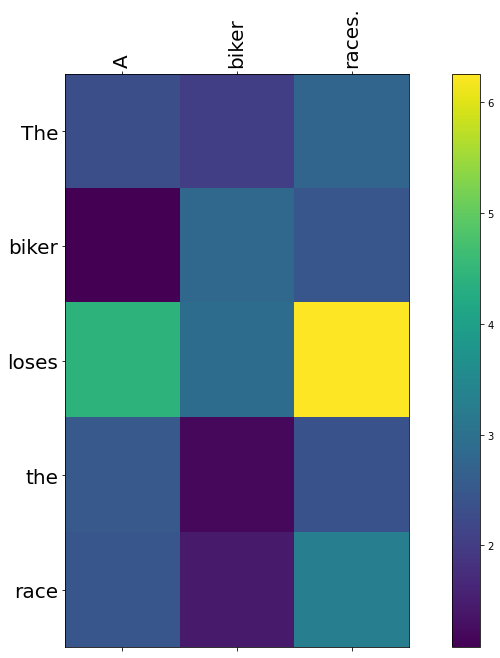

In [ ]:
visualize_token2head_scores(scores, premise, hypothesis)

## Answers
In the following section, you will answer questions about the trained model on the learned attention weights.

You will answer each of the following questions in the notebook. In each question, you will draw a figure that shows the attention weights $e_{ij}$.

In each questions, your figure will be a matrix, where an entry for the $i$th row and $j$th column will visualize the weight $e_{ij}$. Darker values mean larger numbers.

Q1.1 (4 points): Draw a figure that shows the attention weights for a correctly classified example from test set for the entailment, contradiction and the neutral classes, respectively. Explain how the learned attention weights contribute to the correct predictions.

TODO:

Q1.2 (4 points): Draw a figure that shows the attention weights for an incorrectly classified example from test set for the entailment, contradiction and the neutral classes, respectively.

Describe the difference between the pattern in these attention weights with those of the correctly predicted examples above.

TODO:

Q2.1 (2 points): Write your own example of an NLI instance (hypothesis and premise)
such that the label is ambiguous (i.e. write a confusing/hard example!). Draw a figure of
the attention weights and explain how the model’s uncertainty is reflected in the weights.

TODO:

Q2.2 (3 points): Make up two examples yourself, such that the two examples have
similar words (but need not be identical) but the word order makes a difference in the
label. Show the attention weights for each case. Compare the weights in each case and
explain how they contribute to the model predictions.

TODO:

Q3.1 (7 points): Randomly initialize the model and start training from scratch. Train
for 3 epochs. On a fast GPU, this will be 1 minute per epoch, but it may be slower on
older GPUs. Select an example from the training set and plot the attention weights of the
model after the third epoch versus those of the fully trained model. Draw a figure of each
of the attention weights and describe the difference.

TODO:

# You're Done!

You are finished. Print this notebook to a PDF and submit.